# [Soy Bean Desease (Small) Dataset](https://archive.ics.uci.edu/dataset/91/soybean+small)

A small subset of Michalski's famous soybean disease database

### Estrutura do dataset

| Alvo  | Valores |
| ------------- | ------------- |
|class| {D1, D2, D3, D4, }| 

| Features  | Valores |
| ------------- | ------------- |
|date| {4, 5, 3, 6, 0, 2, 1, }| 
|plant-stand| {0, 1, }| 
|precip| {2, 0, 1, }| 
|temp| {1, 2, 0, }| 
|hail| {1, 0, }| 
|crop-hist| {1, 3, 2, 0, }| 
|area-damaged| {0, 1, 2, 3, }| 
|severity| {1, 2, }| 
|seed-tmt| {0, 1, }| 
|germination| {2, 1, 0, }| 
|plant-growth| {1, }| 
|leaves| {1, 0, }| 
|leafspots-halo| {0, }| 
|leafspots-marg| {2, }| 
|leafspot-size| {2, }| 
|leaf-shread| {0, }| 
|leaf-malf| {0, }| 
|leaf-mild| {0, }| 
|stem| {1, }| 
|lodging| {0, 1, }| 
|stem-cankers| {3, 0, 1, 2, }| 
|canker-lesion| {1, 0, 3, 2, }| 
|fruiting-bodies| {1, 0, }| 
|external-decay| {1, 0, }| 
|mycelium| {0, 1, }| 
|int-discolor| {0, 2, }| 
|sclerotia| {0, 1, }| 
|fruit-pods| {0, 3, }| 
|fruit-spots| {4, }| 
|seed| {0, }| 
|mold-growth| {0, }| 
|seed-discolor| {0, }| 
|seed-size| {0, }| 
|shriveling| {0, }| 
|roots| {0, 1, }| 

### Instalação das dependências

In [27]:
import pandas as pd

from sklearn.model_selection import train_test_split

from ucimlrepo import fetch_ucirepo 
pd.options.mode.copy_on_write = True

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torch.nn as nn
import torchmetrics

import torchhd
from torchhd.models import  IntRVFL
from torchhd import embeddings

# Use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

DIMENSIONS = 10000
NUM_LEVELS = 1000
HIDDEN_LAYERS = 45 # O aumento de hidden layers pode gerar problemas de performance.
BATCH_SIZE = 1 

Using cpu device


### Importando o dataset

In [28]:
# fetch dataset 
dataset = fetch_ucirepo(id=91) 
  
# data (as pandas dataframes) 
X = dataset.data.features 
Y = dataset.data.targets 

# Transform labels to int
# Transform labels to int
target_class = 'class'

labels = Y[target_class].unique()
for i in range(len(labels)):
  Y.loc[Y[target_class]==labels[i], target_class] = i


### One-hot Encoding das features

In [29]:
cat_fatures = []
for feature in dataset.data.features:
    #print(feature)
    feature_info = dataset.variables.loc[dataset.variables["name"] == feature]
    if feature_info.type.values[0] == "Categorical":
        cat_fatures.append(feature)


In [30]:
X = pd.get_dummies(X,columns=cat_fatures, dtype=int)

### Dividindo os conjuntos de teste e treino

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size= 0.3, random_state = 28)
y_true = list(y_test[target_class])

y_train= y_train.astype(int)
y_test= y_test.astype(int)

num_classes = len(labels)
num_features = len(x_train.columns)


### HDC

Classificação utilizando o modelo IntRVFL implementado pelo torchhd.

Os modelos e encoders foram feitos a partir de adaptações do código do [exemplo apresentado na documentação do torchhd ](https://torchhd.readthedocs.io/en/stable/classification.html)

#### Record-based enconding dos dados

In [32]:
class RecordEncoder(nn.Module):
        def __init__(self, out_features, size, levels):
                super(RecordEncoder, self).__init__()
                self.position = embeddings.Random(size, out_features)
                self.value = embeddings.Level(levels, out_features)

        def forward(self, x):
                sample_hv = torchhd.bind(self.position.weight, self.value(x)) # Bind da posicao com os valores dos hipervetores
                sample_hv = torchhd.multiset(sample_hv) # Bundle de todos os hipervetores
                return torchhd.hard_quantize(sample_hv)

record_encode = RecordEncoder(DIMENSIONS, num_features, NUM_LEVELS)
record_encode = record_encode.to(device)


record_model = IntRVFL(DIMENSIONS, HIDDEN_LAYERS, num_classes)
record_model = record_model.to(device)

#### Treinamento

In [33]:
with torch.no_grad():
                samples = torch.tensor(x_train.values).to(device)
                labels = torch.tensor(y_train.values).squeeze().to(device)

                """ Treinamento record-based"""
                samples_hv = record_encode(samples)
                record_model.fit_ridge_regression(samples_hv, labels)

#### Teste

In [34]:
record_accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)

with torch.no_grad():
        samples = torch.tensor(x_test.values).to(device)
        labels = torch.tensor(y_test.values).squeeze().to(device)

        """ Testes record-based"""
        samples_hv = record_encode(samples)
        outputs = record_model(samples_hv)
        record_accuracy.update(outputs.cpu(), labels)

record_acc = round((record_accuracy.compute().item() * 100), 2)
print(f"Acuracia obtida por record-based encoding: {record_acc}%")

Acuracia obtida por record-based encoding: 100.0%


#### N-gram based enconding dos dados

In [35]:
class NGramEncoder(nn.Module):
        def __init__(self, out_features, size, levels,n=3):
                super(NGramEncoder, self).__init__()
                self.position = embeddings.Random(size, out_features)
                self.value = embeddings.Level(levels, out_features)
                self.n = n

        def forward(self, x):
                sample_hv = torchhd.bind(self.position.weight, self.value(x)) # Bind da posicao com os valores dos hipervetores
                sample_hv = torchhd.ngrams(sample_hv,self.n) # n-gram dos hipervetores
                return torchhd.hard_quantize(sample_hv)

n_gram_encode = NGramEncoder(DIMENSIONS, num_features, NUM_LEVELS)
n_gram_encode = n_gram_encode.to(device)

n_gram_model = IntRVFL(DIMENSIONS, HIDDEN_LAYERS, num_classes)
n_gram_model = n_gram_model.to(device)

#### Treinamento

In [36]:
with torch.no_grad():
                samples = torch.tensor(x_train.values).to(device)
                labels = torch.tensor(y_train.values).squeeze().to(device)

                """ Treinamento n-gram based"""
                samples_hv = n_gram_encode(samples)
                n_gram_model.fit_ridge_regression(samples_hv, labels)

#### Teste

In [37]:
n_gram_accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)

with torch.no_grad():
        samples = torch.tensor(x_test.values).to(device)
        labels = torch.tensor(y_test.values).squeeze().to(device)

        """ Testes n-gram based"""
        samples_hv = n_gram_encode(samples)
        outputs = n_gram_model(samples_hv)
        n_gram_accuracy.update(outputs.cpu(), labels)

n_gram_acc = round((n_gram_accuracy.compute().item() * 100), 2)
print(f"Acuracia obtida por n-gram based encoding: {n_gram_acc}%")

Acuracia obtida por n-gram based encoding: 100.0%


### Comparação entre codificações

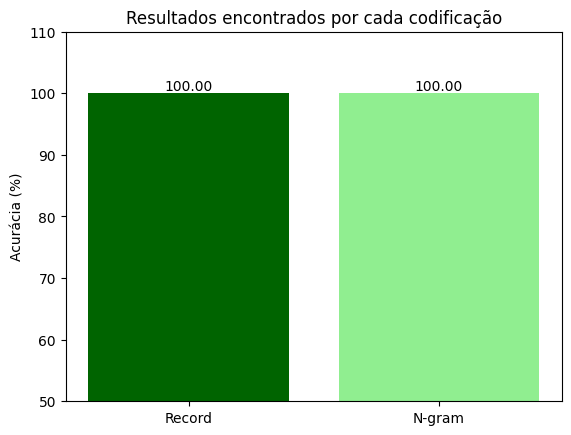

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

encodings = ['Record', 'N-gram']
counts = [record_acc, n_gram_acc]
bar_colors = ['darkgreen', 'lightgreen']

bar = ax.bar(encodings, counts, color=bar_colors)

ax.set_ylabel('Acurácia (%)')
ax.set_title('Resultados encontrados por cada codificação')
ax.set_ylim(50, 110)
ax.bar_label(bar, fmt='{:,.2f}')
plt.show()